### Date: 05/27/2015 10 pm

this notebook is to investigate into the response variables, and fix the specific metric to classify/regress against

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import requests
from pattern import web
import random

In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [3]:
# read in the talk_df_small json file
talks = pd.read_json('talk_df_small.json')

## split out test set

In [4]:
talks.shape

(1885, 31)

In [5]:
testrows = random.sample(talks.index,350)

In [6]:
test = talks.ix[testrows]

In [7]:
train = talks.drop(testrows)

In [8]:
test.shape

(350, 31)

In [9]:
train.shape

(1535, 31)

### Save both test and train dataframe 

In [10]:
# read in the train set
train = pd.read_json('train.json')

In [11]:
train.reset_index(drop = True, inplace = True)

In [12]:
# select only the rating words
ratings = train.ix[:,:14]

In [13]:
ratings.shape

(1535, 14)

### read in test ratings 

In [14]:
test = pd.read_json('test.json')

In [15]:
test.reset_index(drop = True, inplace = True)

In [16]:
test_ratings = test.ix[:,:14]

In [17]:
test_ratings.shape

(350, 14)

##reduce the dimension of the multi-class problem 

###1. Cluster talks based on the rating words, then look at the rating words distribution in each cluster 

In [18]:
ratings = ratings.fillna(0)

In [19]:
# normalize against total ratings one talk receives
ratingsum = ratings.sum(axis = 1)

In [20]:
ratingsum.min()

176.0

In [21]:
ratingwords = list(ratings.columns)

In [22]:
ratings = ratings[ratingwords].div(ratingsum,axis = 'index')

In [23]:
ratings['id'] = train['id']
ratings.set_index('id',inplace = True)

In [24]:
ratings.head()

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,OK,Obnoxious,Persuasive,Unconvincing
id,,,,,,,,,,,,,,
1,0.020121,0.020523,0.050704,0.040241,0.185111,0.154125,0.020121,0.143260,0.034205,0.038229,0.065996,0.046680,0.094567,0.086117
2,0.029782,0.000000,0.084712,0.091992,0.009927,0.156188,0.178028,0.285903,0.040371,0.009265,0.017869,0.001985,0.087359,0.006618
2167,0.015021,0.003577,0.019313,0.143777,0.010014,0.230329,0.173104,0.233190,0.016452,0.018598,0.037911,0.000715,0.077253,0.020744
3,0.047927,0.028497,0.159326,0.049223,0.011658,0.242228,0.034974,0.129534,0.037565,0.023316,0.054404,0.014249,0.129534,0.037565
99,0.137476,0.009416,0.022599,0.011299,0.431262,0.015066,0.077213,0.035782,0.009416,0.011299,0.131827,0.052731,0.024482,0.030132


In [25]:
ratingm = ratings.as_matrix()

In [26]:
ratingm.shape

(1535, 14)

### scale ratingm, so that the low-freq words (negative ones) can have effects in variation

In [41]:
scaler = StandardScaler()

In [42]:
# scale ratingm along the feature columns, so that the low-freq words (negative ones) can have effects in variation
# ratingm_scaled = scale(ratingm)
scaler.fit(ratingm)
ratingm_scaled = scaler.transform(ratingm)

In [43]:
ratingm_scaled.std(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [44]:
ratingm_scaled.shape

(1535, 14)

### Reduce dimension using PCA prior to clustering 

In [98]:
pca = PCA(n_components=6)
reduced = pca.fit_transform(ratingm_scaled)

In [99]:
print '{} variation has been explained by 10 components'.format(pca.explained_variance_ratio_.sum())

0.769517225361 variation has been explained by 10 components


###Find the right number of clusters 

In [100]:
n_cluster = xrange(1,21)

In [101]:
inertias = []
for num in n_cluster:
    clf0 = KMeans(n_clusters = num,n_init = 30)
    clf0.fit(reduced)
    print 'the inertia is {} for {} cluters'.format(clf0.inertia_,num)
    inertias.append(clf0.inertia_)

the inertia is 16536.925173 for 1 cluters
the inertia is 13236.7615876 for 2 cluters
the inertia is 10690.8141935 for 3 cluters
the inertia is 8936.82923351 for 4 cluters
the inertia is 7856.76557405 for 5 cluters
the inertia is 7203.44426836 for 6 cluters
the inertia is 6641.58529931 for 7 cluters
the inertia is 6156.19968817 for 8 cluters
the inertia is 5726.06103579 for 9 cluters
the inertia is 5413.07206894 for 10 cluters
the inertia is 5207.48846458 for 11 cluters
the inertia is 5013.88674564 for 12 cluters
the inertia is 4833.13291634 for 13 cluters
the inertia is 4659.56805203 for 14 cluters
the inertia is 4532.93079944 for 15 cluters
the inertia is 4393.0853594 for 16 cluters
the inertia is 4293.47834013 for 17 cluters
the inertia is 4183.83485696 for 18 cluters
the inertia is 4082.80690585 for 19 cluters
the inertia is 3962.54078027 for 20 cluters


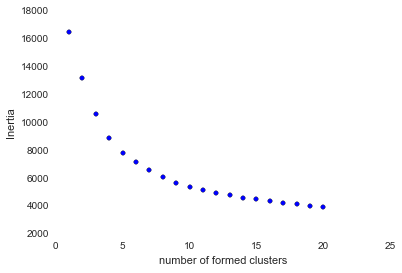

In [108]:
plt.scatter(x = n_cluster, y = inertias, marker = 'o')
plt.xlabel('number of formed clusters')
plt.ylabel('Inertia')

#### Choose 5 clusters, look at the centroids

In [109]:
clf = KMeans(n_clusters = 5,random_state=58)
clf.fit(reduced)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=58, tol=0.0001,
    verbose=0)

In [110]:
clf.inertia_

7856.7655740546452

In [111]:
len(clf.labels_)

1535

In [112]:
clf.labels_[0]

0

In [113]:
cents = clf.cluster_centers_

In [114]:
# get the original space
cents_ori = pca.inverse_transform(cents)

In [115]:
cents_ori.shape

(5, 14)

In [116]:
cents_ori_df = pd.DataFrame(cents_ori,columns = ratingwords)

In [117]:
cents_ori_df

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,OK,Obnoxious,Persuasive,Unconvincing
0,-0.133983,1.681879,-0.387545,-0.409344,-0.091982,-0.163219,-0.188585,-0.679744,-0.471393,1.540513,1.482173,1.508597,-0.313528,1.764300
1,-0.111145,-0.017545,-0.483754,-0.354059,2.855755,-0.483900,0.082932,-0.781062,-0.516253,-0.281881,0.392032,0.694257,-0.591778,-0.200147
2,0.740124,-0.436338,0.915741,-0.698998,-0.257976,-0.752308,-0.469947,1.144757,-0.154222,-0.305530,-0.447832,-0.239689,-0.037422,-0.408956
3,-0.618855,-0.122438,-0.128100,0.102013,-0.239660,0.994124,-0.340286,-0.286944,-0.346468,0.003399,0.091450,-0.235420,0.768114,0.027043
4,0.041569,-0.179791,-0.593103,1.038110,-0.180686,-0.199216,1.110354,-0.412677,1.064400,-0.355725,-0.476208,-0.392077,-0.653189,-0.404128


#### so the above five clusters indicate the following associations
2: (Fascinating, Ingenious, Jaw-dropping)

0: (Informative, Persuasive)

3: (confusing, longwinded, OK, Obnoxious, Unconvincing)

1: (Beautiful,Courageous,Inspiring)

4: (Funny)

#### For now, save labels as the response variable 

In [393]:
response = clf.labels_

In [394]:
type(response)

numpy.ndarray

In [395]:
response.shape

(1535,)

In [58]:
response = pd.Series(response,index = train['id'])

In [59]:
response.to_csv('response5.csv',index_label='id')

###Get the test labels through calculating their distance to each of the centroids, and get the smallest 

In [477]:
reduced_test_ratingsm.shape

(350, 8)

In [478]:
to_cents = clf.transform(reduced_test_ratingsm)

In [479]:
to_cents.shape

(350, 5)

In [480]:
to_cents = pd.DataFrame(to_cents, columns = [0,1,2,3,4])

In [481]:
to_cents.head(2)

,0,1,2,3,4
0,4.803445,5.391871,2.166353,6.492351,5.65912
1,2.726084,2.347600,4.255648,5.924577,5.17906


In [482]:
labels = []
for ind, row in to_cents.iterrows():
    label = row.idxmin()
    labels.append(label)

In [483]:
to_cents['label'] = labels

In [484]:
to_cents.head(10)

,0,1,2,3,4,label
0,4.803445,5.391871,2.166353,6.492351,5.659120,2
1,2.726084,2.347600,4.255648,5.924577,5.179060,1
2,3.584621,1.424049,4.216521,5.268421,4.742974,1
3,6.843279,6.818949,6.264815,7.476249,3.480401,4
4,4.434056,3.190355,2.838952,6.195582,5.233601,2
5,3.513637,4.263589,3.987027,3.203114,4.207114,3
6,2.427438,4.045582,3.891609,3.130650,3.258486,0
7,1.863545,2.768831,4.085037,4.889569,4.722872,0
8,4.361548,1.411188,4.342276,5.649748,5.050606,1
9,2.772204,4.108533,5.084775,6.004385,5.601200,0


In [485]:
test_ratings.head(10)

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,OK,Obnoxious,Persuasive,Unconvincing
id,,,,,,,,,,,,,,
1146,0.013372,0.006977,0.015116,0.250000,0.000000,0.138372,0.215698,0.081395,0.219186,0.016860,0.012209,0.006977,0.020349,0.003488
1153,0.032641,0.002967,0.096439,0.053412,0.000000,0.191395,0.014837,0.336795,0.059347,0.019288,0.007418,0.000000,0.182493,0.002967
1154,0.117083,0.007678,0.219770,0.078695,0.008637,0.131478,0.004798,0.272553,0.036468,0.016315,0.029750,0.013436,0.039347,0.023992
223,0.020984,0.001085,0.025326,0.093343,0.563314,0.003256,0.041245,0.020260,0.142547,0.019537,0.042692,0.016643,0.005065,0.004703
103,0.174612,0.004753,0.047113,0.149448,0.010206,0.054383,0.036488,0.249546,0.215714,0.013281,0.012303,0.002377,0.026422,0.003355
1187,0.141935,0.018065,0.009032,0.158710,0.014194,0.172903,0.038710,0.145806,0.024516,0.015484,0.147097,0.027097,0.025806,0.060645
105,0.011834,0.020710,0.012821,0.085799,0.126233,0.256410,0.061144,0.156805,0.014793,0.075937,0.061144,0.011834,0.064103,0.040434
1189,0.016807,0.017647,0.145378,0.083193,0.001681,0.190756,0.035294,0.182353,0.026891,0.015966,0.024370,0.006723,0.218487,0.034454
1193,0.242326,0.013034,0.148345,0.068599,0.003258,0.029326,0.020580,0.324130,0.040302,0.016121,0.019894,0.009089,0.048705,0.016292


In [488]:
test_response = pd.Series(labels,index = test['id'])

In [490]:
test_response.to_csv('test_response.csv',index_label='id')